# Capstone Project for Machine Learning Nano Degree
## Overview
> Project aims to explore multiple concepts around machine learning methodologies and apply them to classify a financial data set into a tradable or a non tradable node. Once learned, the model can then infer a node or a set of nodes as a possible trade signal or not.

### Problem Domain
> Use machine learning methedologies like deep learning to generate trade signals. Data given has some characteristics that get fed into the model. The model then outputs a binary state expressing a trade or not. 

### Project Origin
> Traders look at financial data mostly technical analysis data and decide to enter a trade, or not, based on certain characteristics of data. For e.g. they look at moving averages of multiple time frames and make a decision based on which moving average is above or below than the other. The idea here is to not focus on a single characteristics like Open price, 8 day moving average etc... but looking at all the input charactersitics at every node / row and learn the model by adjusting weights to match the provided labels. If output of model is close to the label, model increases weights on the parts of network that caused the closeness and reduces weights on the others.

### Data Sets and Input Data
> Input data for this project is a series of timeseries nodes with High, Open, Close, Low and Volume as columns for each sample row of input. These sample rows also contain values of these columns when a trade had happenned and when only a quote was published. The reqid tells us whether the row is from a trade or a quote.

> There are three files that data is loaded from.

> reqids.cvs

__reqid,symbol,quotetype__


*__1001,AAPL,BID_ASK__*

*__1002,CLZ16,BID_ASK__*

*__1003,AAPL,TRADES__*

*__1003,CLZ16,TRADES__*

* Reqids is the id of the request node like 1001 is id for Apple AAPL for all non trade quotes. There are four reqids chosen for this project.
* Symbol is the market symbol of the record. There are two symbols in this dataset.
   * APPL : Apple Inc.
   * CLZ16: Crude Oil Future for December 2016.
* Quote Type column tells whether sample row is a trade or a simple quote.

> header.csv

__ReqId, Date,  Open, High, Low,  Close, Volume, Count, WAP, HasGaps__

* ReqId: Determines symbol of record and whether it was a trade or a quote. see reqid section above for details.
* Date: Date and Time of record.
* Open: Open price for the time period of the record for the symbol.
* High: High price for the time period of the record for the symbol.
* Low: Lowest price for the time period of the record for the symbol.
* Close: Close price for the time period of the record for the symbol.
* Volume: Total volume of contracts tradeed.
* Count: Number of quotes. Ignored for this project.
* WAP: weighted average price for the period of the record. Ignored for this project
* HasGaps: Indicator specifying if price jumped in that time period of the record. Ignored for this project.

> data.csv

* About 22K+ records for both symbols in the order of the header.


## Problem Statement

> Generate a trade signal by classifying a record with a binary signal where true or 1 indicating make a trade and 0 not to trade. Learn the model using dataset of 22K+ records with four major factors, high, low, close and open prices. Project is allowed to create more factors / features if needed. Goal of a project is to evaluate certain models and suggest the optimal model. Suggestion should also report further modifications needed to improve model. Model selection should be based on not only the performance on the given dataset but also on future needs of scaling the model to a larger dataset.


## Metrics

> Models are evaluated based on accuracy as the metric. The model that provides the best accuracy consistently over the test data set should be chosen. Considerations of scaling up in terms of data input should also be considered. Cost is a good to have as a factor to chose but is not a mandatory requirement to chose optimal model.

## Strategy

> Implement few model of different behavior and evaluate them side by side. Implementation will involve deep learning methods and simple classification models. Strategy will 

      1 begin with simple net with two hidden layers
      2 add cnn to 1
      3 add rnn to 2
      4 run the enire set with SVM

Strategy will then compare structure, loss, accuracy and weight distribution for each.

## Data Exploration
### Descriptive Statistics
### Characteristics and Anomalies
## Input Space
## Algorithms and Techniques
### Simple Net
![Simple Net with Two Hidden Layers](graph-simple-net.png)

* This net is a simple neural net with two hidden layers of 10 and 5 neural nodes respectively.
* Input is a 120 * 15 batch that gets fed into a 10 unit layer and then the output of the 10 unit layer gets fed into a 5 unit layer. Finally, output of the 5 unit layer is fed into a softmax layer that outputs two classes, yes or no. Yes (1) meaning it is a trade and no (0) meaning no trade.
* The diagram shows the execution graph followed by this net

### CNN + Dropout
![CNN Net with dropout attached to simple net](graph-cnn-net.png)

* This net is a convolution net that takes the same input as the simple net and reshapes the input to match 15 @ 8/15 convolution net. There are 15 matrices of 8,15 size. 
* Idea behind this configuration is that we need to look at 8 rows or 15 original features at one time. We do this 15 times.
* We also add a pooling layer with stride 2,2 and filter 2,2 that will reduce the output to 15 @ 4,4
* This output reshaped to 16,15 would then be forwarded to the simple net. 
### RNN
![RNN Net attached to CNN above](graph-rnn-net.png)

* This net is a combination of CNN and RNN net.
* Convolution net as descibed above. 
* This output reshaped to 16,15 would then be forwarded to the rnn of shape 16,15 and a time step of 8.
* Output of this rnn is 128,15 (16*8, 15) which is forwarded to the simple net.


## Load Data

There are three files to load
headers.csv which indicates column headers. used for dataframe column names
reqids.csv which tells symbols and whether it is a trade record or a quote
data.csv which is the real data and will need some wrangling

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import re
import numpy.core.defchararray as npc
from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow import summary

DATA_FILE="data.csv"
HEADER_FILE="header.csv"
REQIDS_FILE="reqids.csv"

print("loading header")
header = pd.read_csv(HEADER_FILE)
header.columns = [s.strip() for s in header.columns.values]
h = header.columns.values
print("loading dataset")
raw_data = pd.read_csv(DATA_FILE, names=h, dtype = {'Date': str, 'ReqId': np.int, 'Open' : np.float64\
        , 'Close' : np.float64, 'High' : np.float64, 'Low' : np.float64, 'Volume' : np.float64})
print("loading reqids")
reqids = pd.read_csv(REQIDS_FILE)


loading header
loading dataset
loading reqids


## Preprocess

* Some clean up is required before this data can be used for training.
* Some additional features must be added to this original data set for better learning and avoid overfitting.
* Some original features must be deleted as they are redundant for training.

__Cleanup__
* Rows have a indication record showing end of quote or trade record. These must be cleaned up
* Additional features are added

   * Short Term Exponential Moving Average: ShortEMA. This is a 5 or 8 period average. We chose 5. 
   * Long Term Exponential Moving Average: LongEMA. This is a 21 day moving average.
   * Bollinger Band: BBAUpper, BBALower. Upper and Lower bands are 2 Standard Deviations away from a 21 Day Exponential Moving Average
   * Last Minimum: Last lowest price on a 21 period window
   * Last Maximum: Last highest price on a 21 period window
* Remove first 21 rows as the largest additional feature calculated is a 21 period calculation which means first 20 rows will not have valid values for this calculated feature. This will deteriorate training or make it impossible to learn.

In [2]:
print(pd.__name__, pd.__version__)
import pandas.core
from pandas.core import window
from pandas.core.window import EWM

def preprocess_raw_data(raw_data, reqids):
    dcol = raw_data['Date']
    dcolf = dcol.str.match("finished-")
    raw_data_wo_finish = raw_data[~dcolf]
    rownum = raw_data_wo_finish.shape[0]
    raw_data_wo_finish['Date'] = pd.DatetimeIndex(pd.to_datetime(raw_data_wo_finish['Date'], format="%Y%m%d %H:%M:%S"))
    raw_data_wo_finish['ReqId'] = raw_data_wo_finish['ReqId'].astype(int)
    raw_data_wo_finish['Open'] = raw_data_wo_finish['Open'].astype(float)
    raw_data_wo_finish['High'] = raw_data_wo_finish['High'].astype(float)
    raw_data_wo_finish['Low'] = raw_data_wo_finish['Low'].astype(float)
    raw_data_wo_finish['Close'] = raw_data_wo_finish['Close'].astype(float)
    raw_data_wo_finish = pd.merge(raw_data_wo_finish, reqids, on=['ReqId'])
    raw_data_wo_finish = pd.get_dummies(data = raw_data_wo_finish, columns = ['QuoteType', 'Symbol'])
    del raw_data_wo_finish['Volume']
    del raw_data_wo_finish['HasGaps']
    del raw_data_wo_finish['WAP']
    del raw_data_wo_finish['Count']
    del raw_data_wo_finish['ReqId']
    ### lets add more features
    ### 5 period moving average MA
    ### 21 period moving average with bollinger bands bb
    ### 21 period min
    ### 21 period max
    ### TODO:
    ### these periods could be parameterized to describe and evaluate models later on
    raw_data_wo_finish['ShortEMA'] = np.round(raw_data_wo_finish['Close'].ewm(span=5).mean(), 3)
    raw_data_wo_finish['LongEMA']  = np.round(raw_data_wo_finish['Close'].ewm(span=21).mean(), 3)
    raw_data_wo_finish['BBAUpper'] = np.round(2 * raw_data_wo_finish['Close'].ewm(span=21).std() + raw_data_wo_finish['Close'], 3)
    raw_data_wo_finish['BBALower'] = np.round(raw_data_wo_finish['Close'] - 2 * raw_data_wo_finish['Close'].ewm(span=21).std(), 3)
    raw_data_wo_finish['LastMin']  = np.round(raw_data_wo_finish['Close'].rolling(window=21).min(), 3)
    raw_data_wo_finish['LastMax']  = np.round(raw_data_wo_finish['Close'].rolling(window=21).max(), 3)
    ### remove first 20 rows
    raw_data_wo_finish = raw_data_wo_finish.loc[20:,:]
    raw_data_wo_finish = raw_data_wo_finish.reset_index()
    print(raw_data_wo_finish.head())
    return raw_data_wo_finish

data = preprocess_raw_data(raw_data, reqids)
data.head()
print("post process describe")
display(data.describe())

print("reqids ...")
display(reqids)


pandas 0.19.2


d:\anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda3\lib

   index                Date   Open   High    Low  Close  QuoteType_BID_ASK  \
0     20 2016-11-03 17:20:00  44.68  44.69  44.67  44.69                  1   
1     21 2016-11-03 17:21:00  44.69  44.73  44.68  44.70                  1   
2     22 2016-11-03 17:22:00  44.71  44.73  44.71  44.73                  1   
3     23 2016-11-03 17:23:00  44.72  44.74  44.71  44.73                  1   
4     24 2016-11-03 17:24:00  44.72  44.74  44.71  44.73                  1   

   QuoteType_TRADES  Symbol_AAPL  Symbol_CLZ16  ShortEMA  LongEMA  BBAUpper  \
0                 0            0             1    44.689   44.675    44.741   
1                 0            0             1    44.693   44.678    44.751   
2                 0            0             1    44.705   44.683    44.788   
3                 0            0             1    44.713   44.688    44.792   
4                 0            0             1    44.719   44.692    44.795   

   BBALower  LastMin  LastMax  
0    44.639    44.

,index,Open,High,Low,Close,QuoteType_BID_ASK,QuoteType_TRADES,Symbol_AAPL,Symbol_CLZ16,ShortEMA,LongEMA,BBAUpper,BBALower,LastMin,LastMax
count,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000
mean,10257.500000,87.949620,88.088826,87.907819,88.062044,0.561438,0.438562,0.444716,0.555284,88.055896,88.031303,88.347929,87.776160,87.893586,88.174035
std,5911.056392,30.875283,30.838791,30.891753,30.831320,0.496223,0.496223,0.496946,0.496946,30.829414,30.824813,31.033311,30.780286,30.828215,30.860927
min,20.000000,1.000000,43.140000,0.010000,43.110000,0.000000,0.000000,0.000000,0.000000,43.184000,43.344000,43.454000,42.663000,43.110000,43.400000
25%,5138.750000,44.930000,44.960000,44.910000,44.940000,0.000000,0.000000,0.000000,0.000000,44.940000,44.940000,45.059000,44.860000,44.880000,45.010000
50%,10257.500000,109.300000,109.400000,109.260000,109.400000,1.000000,0.000000,0.000000,1.000000,109.400000,109.395000,109.637000,109.040500,109.220000,109.500000
75%,15376.250000,110.310000,110.390000,110.270000,110.370000,1.000000,1.000000,1.000000,1.000000,110.355250,110.349000,110.449000,110.164250,110.240000,110.410000
max,20495.000000,111.950000,130.250000,111.950000,119.000000,1.000000,1.000000,1.000000,1.000000,114.009000,113.656000,177.471000,112.997000,114.010000,119.000000


reqids ...


,ReqId,Symbol,QuoteType
0,1001,AAPL,BID_ASK
1,1002,CLZ16,BID_ASK
2,1003,AAPL,TRADES
3,1003,CLZ16,TRADES


## Raw Data
### Describe

,ReqId,Open,High,Low,Close,Volume,Count,WAP,HasGaps
count,22910.000000,22910.000000,22910.000000,22910.000000,22910.000000,22910.000000,22910.000000,22910.000000,22910.0
mean,1002.596945,70.568454,70.694167,70.530062,70.668991,134.365212,45.905194,34.518787,0.0
std,1.116314,31.943321,31.969677,31.947299,31.960129,741.080166,137.766111,42.205519,0.0
min,1001.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0
25%,1002.000000,44.730000,44.750000,44.710000,44.730000,-1.000000,-1.000000,-1.000000,0.0
50%,1002.000000,45.090000,45.110000,45.070000,45.090000,-1.000000,-1.000000,-1.000000,0.0
75%,1004.000000,109.770000,109.850000,109.720000,109.820000,78.000000,39.000000,45.078000,0.0
max,1004.000000,111.950000,130.250000,111.950000,119.000000,56940.000000,6667.000000,111.950000,0.0


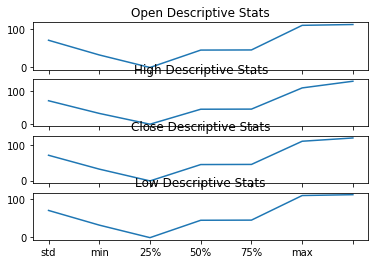

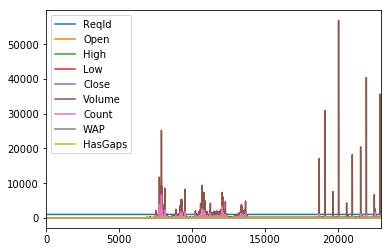

In [3]:
raw_describe = raw_data.describe() 
display(raw_describe)
plt.figure(1)
fig, axs = plt.subplots(4, sharex=True)
raw_data.plot()

xcoord = np.arange(7)
xcoord_labels = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
raw_describe_open = raw_data.describe()['Open'][1:,]
axs[0].plot(xcoord, raw_describe_open[:])
axs[0].set_title("Open Descriptive Stats")
axs[0].set_xticklabels(xcoord_labels)

raw_describe_high = raw_data.describe()['High'][1:,]
axs[1].plot(xcoord, raw_describe_high[:])
axs[1].set_title("High Descriptive Stats")

raw_describe_close = raw_data.describe()['Close'][1:,]
axs[2].plot(xcoord, raw_describe_close[:])
axs[2].set_title("Close Descriptive Stats")

raw_describe_low = raw_data.describe()['Low'][1:,]
axs[3].plot(xcoord, raw_describe_low[:])
axs[3].set_title("Low Descriptive Stats")

plt.show()


### Analysis
We are dealing with Crude Oil and Apple. Crude oil trading in 40+ prices and Apple in 100+ prices. This is already a wider range than required to learn a model. Automatically, Apple prices will carry more weight as they will effect the learning gradient more than Crude oil.

This is what is shown in the charts above. Notice how high some histogram goes and vary from 0 to 50,000. That is a very biased data to train.

In the descriptive charts above we can see how min of open is lower to 30 and max of open is higher to 100. That is a very spread out data. Spread out data is unsuitable for training. Similar arguments can be made for other columns.

## Pre Processed Data
### Describe

,index,Open,High,Low,Close,QuoteType_BID_ASK,QuoteType_TRADES,Symbol_AAPL,Symbol_CLZ16,ShortEMA,LongEMA,BBAUpper,BBALower,LastMin,LastMax
count,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000,20476.000000
mean,10257.500000,87.949620,88.088826,87.907819,88.062044,0.561438,0.438562,0.444716,0.555284,88.055896,88.031303,88.347929,87.776160,87.893586,88.174035
std,5911.056392,30.875283,30.838791,30.891753,30.831320,0.496223,0.496223,0.496946,0.496946,30.829414,30.824813,31.033311,30.780286,30.828215,30.860927
min,20.000000,1.000000,43.140000,0.010000,43.110000,0.000000,0.000000,0.000000,0.000000,43.184000,43.344000,43.454000,42.663000,43.110000,43.400000
25%,5138.750000,44.930000,44.960000,44.910000,44.940000,0.000000,0.000000,0.000000,0.000000,44.940000,44.940000,45.059000,44.860000,44.880000,45.010000
50%,10257.500000,109.300000,109.400000,109.260000,109.400000,1.000000,0.000000,0.000000,1.000000,109.400000,109.395000,109.637000,109.040500,109.220000,109.500000
75%,15376.250000,110.310000,110.390000,110.270000,110.370000,1.000000,1.000000,1.000000,1.000000,110.355250,110.349000,110.449000,110.164250,110.240000,110.410000
max,20495.000000,111.950000,130.250000,111.950000,119.000000,1.000000,1.000000,1.000000,1.000000,114.009000,113.656000,177.471000,112.997000,114.010000,119.000000


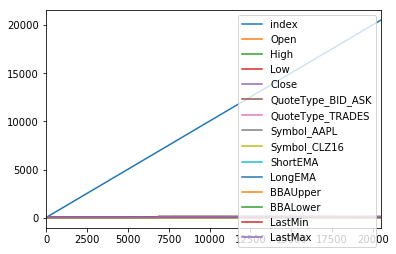

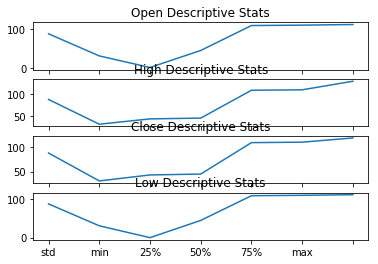

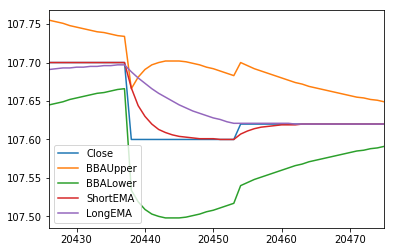

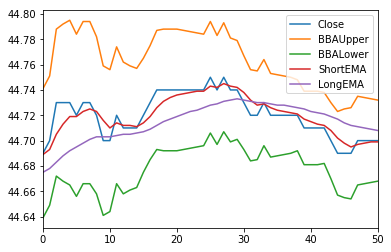

In [4]:
display(data.describe())
data.plot()
plt.figure(2)
fig, axs = plt.subplots(4, sharex=True)

data_describe_open = data.describe()['Open'][1:,]
axs[0].plot(xcoord, data_describe_open[:])
axs[0].set_title("Open Descriptive Stats")
axs[0].set_xticklabels(xcoord_labels)

data_describe_high = data.describe()['High'][1:,]
axs[1].plot(xcoord, data_describe_high[:])
axs[1].set_title("High Descriptive Stats")

data_describe_close = data.describe()['Close'][1:,]
axs[2].plot(xcoord, data_describe_close[:])
axs[2].set_title("Close Descriptive Stats")

data_describe_low = data.describe()['Low'][1:,]
axs[3].plot(xcoord, data_describe_low[:])
axs[3].set_title("Low Descriptive Stats")

bbdata = data.loc[:,['Close', 'BBAUpper', 'BBALower', 'ShortEMA', 'LongEMA'] ]
bbdata = bbdata[-50:]
bbdata.plot()

bbdata2 = data.loc[:,['Close', 'BBAUpper', 'BBALower', 'ShortEMA', 'LongEMA'] ]
bbdata2 = bbdata2.loc[0:50,:]
bbdata2.plot()

plt.show()

### Analysis

After adding more features we see that the bias in data still exists. The lower two charts show additional features per symbol. As we can see, data for each symbol is still very variable. This calls for standardizing data.

## Standardize and Filter Outliers

### Prepare Training Set

* Generate Labels
   * We decide how many periods to look ahead at each node for each symbol. 
   * Then we calculate the farthest the price of the symbol within the symbol's look ahead period.
   * If the price move is more than look ahead range for that symbol, label the record 1

In [5]:
from sklearn import preprocessing
training_data = data[:]
del training_data['Date']
### generate labels
HYPER_PERIODS_LOOK_AHEAD = 10
HYPER_RANGE_LOOK_AHEAD_CL = .10
HYPER_RANGE_LOOK_AHEAD_AAPL = .5
    
def generate_labels(training_data, lookahead, range_cl, range_aapl):
    end = training_data.shape[0]
    
    #print('end: ', end)
    labels = np.zeros((end, 1))
    for begin in np.arange(end):
        if begin % 5000 == 0:
            print('progress...', begin, ' records')
        #print("begin:", begin)
        close = training_data.iloc[begin, 3]
        #print('close at begin:', close)
        look_ahead_begin = begin + 1
        look_ahead_end = (look_ahead_begin + HYPER_PERIODS_LOOK_AHEAD) % end
        #print('look_ahead_end: ', look_ahead_end)
        look_ahead_data = training_data.loc[look_ahead_begin:look_ahead_end, ['Open', 'Close', 'High', 'Low', 'Symbol_AAPL', 'Symbol_CLZ16']]
        for rownum in range(look_ahead_begin,look_ahead_end):
            #print('rownum: ', rownum)
            row = look_ahead_data.loc[rownum,:]
            #print('got row: ', row)
            max_price = np.max(row)
            #print('maxprice: ', max_price)
            if row['Symbol_CLZ16'] == 1:
                if np.abs(close - max_price) >= HYPER_RANGE_LOOK_AHEAD_CL:
                    #print('range in CL: ', np.abs(close - max_price), ' Close: ', close, ' Max: ', max_price)
                    labels[begin] = 1
                #else:
                #    labels[begin][1] = 1
            elif row['Symbol_AAPL'] == 1:
                if np.abs(close - max_price) >= HYPER_RANGE_LOOK_AHEAD_AAPL:
                    #print('range in AAPL: ', np.abs(close - max_price), ' Close: ', close, ' Max: ', max_price)
                    labels[begin] = 1
                #else:
                #    labels[begin][1] = 1
    
    
    print('found ', np.sum(labels), 'possible trades')
    with tf.name_scope("labels"):
        summary.scalar("LookAheadPeriod", lookahead)
        summary.scalar("RangeCL", range_cl)
        summary.scalar("RangeAAPL", range_aapl)
        summary.scalar("PotentialTrades", np.sum(labels))
    return labels
    
    

training_labels = generate_labels(training_data, HYPER_PERIODS_LOOK_AHEAD, HYPER_RANGE_LOOK_AHEAD_CL,\
                             HYPER_RANGE_LOOK_AHEAD_AAPL )
standardized_data = preprocessing.scale(training_data)
print('data is standardized and ready to train')


progress... 0  records
progress... 5000  records
progress... 10000  records
progress... 15000  records
progress... 20000  records
found  6507.0 possible trades
data is standardized and ready to train


## Split DataSet into Train, CrossValidation and Test

Split 60/20/20 into train, validation and test data set

In [6]:
### lets take a peek at our data
print(standardized_data[-5:])
total_rows, total_cols = standardized_data.shape[0], standardized_data.shape[1]
print('TotalRows: ', total_rows, ' TotalCols: ', total_cols)
print('Training Data Columns: ', training_data.columns.values)


[[ 1.73128951  0.63710706  0.63334685  0.63812054  0.63436899 -1.13144959
   1.13144959 -0.89491872  0.89491872  0.63460765  0.63550022  0.62215542
   0.64357179  0.63924867  0.63013142]
 [ 1.73145868  0.63710706  0.63334685  0.63812054  0.63436899 -1.13144959
   1.13144959  1.11741992 -1.11741992  0.63460765  0.63550022  0.6221232
   0.64360428  0.63924867  0.63013142]
 [ 1.73162786  0.63710706  0.63334685  0.63812054  0.63436899 -1.13144959
   1.13144959 -0.89491872  0.89491872  0.63460765  0.63550022  0.62205875
   0.64366926  0.63924867  0.63013142]
 [ 1.73179704  0.63710706  0.63334685  0.63812054  0.63436899 -1.13144959
   1.13144959  1.11741992 -1.11741992  0.63460765  0.63550022  0.62202653
   0.64370175  0.63989744  0.63013142]
 [ 1.73196622  0.63710706  0.63334685  0.63812054  0.63436899 -1.13144959
   1.13144959 -0.89491872  0.89491872  0.63460765  0.63550022  0.62196208
   0.64376673  0.63989744  0.63013142]]
TotalRows:  20476  TotalCols:  15
Training Data Columns:  ['index

In [7]:
train_len = int(0.6 * total_rows)
validate_len = int(0.2 * total_rows)
test_len = int(0.2 * total_rows)

std_train_data = standardized_data[0:train_len]
std_train_label = training_labels[0:train_len, 0]
print("Train positives: ", np.sum(std_train_label))
std_validate_data = standardized_data[train_len+1:train_len + 1 + validate_len]
std_validate_label = training_labels[train_len+1:train_len + 1 + validate_len, 0]
print("Validate positives: ", np.sum(std_validate_label))
test_start = train_len + validate_len + 1
std_test_data = standardized_data[test_start:test_start + test_len]
std_test_label = training_labels[validate_len+1:validate_len + 1 + test_len, 0]
print("Test positives: ", np.sum(std_test_label))
print('training len: ', train_len, ', validate len: ', validate_len, ', \
test len: ', test_len, ', total rows: ', total_rows)
print('training shape: ', std_train_data.shape, std_train_label.shape)
print('validation shape: ', std_validate_data.shape, std_validate_label.shape)
print('test shape: ', std_test_data.shape, std_test_label.shape)

Train positives:  3555.0
Validate positives:  888.0
Test positives:  1556.0
training len:  12285 , validate len:  4095 , test len:  4095 , total rows:  20476
training shape:  (12285, 15) (12285,)
validation shape:  (4095, 15) (4095,)
test shape:  (4095, 15) (4095,)


## Prepare for Training


In [8]:
import math

np.random.seed(40)

def build_training_feed(batch_size, dataset, labels):
    data_rows = dataset.shape[0]
    label_rows = labels.shape[0]
    if dataset.shape[0] < batch_size:
        raise("data ", data_rows, " needs more than batch_size ", batch_size, " cannot train")
    if data_rows != label_rows:
        raise("data and labels must be of same size: ", data_rows, label_rows)
        
    random_index_start = np.random.choice(np.arange(data_rows - batch_size), 1)
    tf.summary.scalar("RandomIndexStart", random_index_start)
    random_index_end = random_index_start + batch_size
    
    return {X: dataset[random_index_start: random_index_end], y: \
            labels[random_index_start: random_index_end], batch_start_index : random_index_start} 

HYPER_BATCH_SIZE = 120
HYPER_LEARNING_RATE = 0.1

def build_training_set_placeholders(batch_size, input_features):
    ### input        
    X = tf.placeholder(tf.float32, shape=(None, input_features), name = "X")
    y = tf.placeholder(tf.int32, shape=(None), name = "y")        
    return X, y
    
def build_simple_net(X, input_features, num_hidden1, num_hidden2):
    
    ### hidden1
    with tf.name_scope("hidden1"):
        h1w = tf.Variable(tf.truncated_normal([input_features, num_hidden1],\
                          stddev = 1.0 / math.sqrt(float(input_features))), name="weights")
        h1b = tf.Variable(tf.zeros(num_hidden1), name="biases")
        hidden1 = tf.nn.relu(tf.matmul(X, h1w) + h1b)
        tf.summary.histogram("weights", h1w)
        tf.summary.histogram("biases", h1b)
    
    with tf.name_scope("hidden2"):
        h2w = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2],\
                                             stddev = 1.0 / math.sqrt(float(num_hidden1))), name="weights")
        h2b = tf.Variable(tf.zeros(num_hidden2), name = "biases")
        hidden2 = tf.nn.relu(tf.matmul(hidden1, h2w) + h2b)
        tf.summary.histogram("weights", h2w)
        tf.summary.histogram("biases", h2b)
    
    with tf.name_scope("softmax"):
        smw = tf.Variable(tf.truncated_normal([num_hidden2, 2], \
                          stddev = 1.0 / math.sqrt(float(num_hidden2))), name = "weights")
        smb = tf.Variable(tf.zeros(2), name = "biases")
        logits = tf.matmul(hidden2, smw) + smb
        tf.summary.histogram("weights", smw)
        tf.summary.histogram("biases", smb)
    
    with tf.name_scope("building"):
        tf.summary.scalar("InputFeatures", input_features)
        tf.summary.scalar("Hidden1",num_hidden1)
        tf.summary.scalar("Hidden2", num_hidden2)
    
    return logits

def build_loss(logits, labels):
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits\
                , labels = labels, name = "xentropy")
    tf.summary.histogram("xentropy", cross_entropy)
    loss = tf.reduce_mean(cross_entropy, name="xentropy_mean")
    tf.summary.scalar("loss", loss)
    return loss

def build_train(loss, learning_rate):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    tf.summary.scalar("LearningRate", learning_rate)
    train_op = optimizer.minimize(loss, global_step = global_step)
    tf.summary.scalar("GlobalStep", global_step)
    return train_op

def build_eval(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accurate = tf.reduce_sum(tf.cast(correct, tf.int32))
    tf.summary.scalar("Accurate", accurate)
    return accurate


## Lets Build Training Cycle


In [10]:
import os

with tf.Graph().as_default():
    ## global step
    batch_start_index = tf.placeholder(tf.int32, shape=(1), name="BatchStartIndex")
    global_step = tf.Variable(0, name="global_step", trainable=False)
    print("Global Step", global_step)
    learning_rate = tf.train.exponential_decay(HYPER_LEARNING_RATE, global_step,\
            HYPER_BATCH_SIZE, 0.95, staircase=True)
    print("Learning Rate", learning_rate)
    tf.summary.scalar("GlobalStep", global_step)
    tf.summary.scalar("LearningRate", learning_rate)

    input_features = std_train_data.shape[1]
    print("input_features %d" % (input_features))
    X, y = build_training_set_placeholders(HYPER_BATCH_SIZE, input_features)
    print("X", X)
    print("y", y)
    
    
    print("validation data ", std_validate_data.shape, " validation label ", std_validate_label.shape)
    print("test data ", std_test_data.shape, " test label ", std_test_label.shape)
    
    logits = build_simple_net(X, input_features, 10, 5)  
    print("logits", logits)
    loss = build_loss(logits, y)
    print("loss", loss)
    trop = build_train(loss, learning_rate)
    print("Training Op", trop)
    accurate = build_eval(logits, y)
    print("Accuracy", accurate)
    print("Initializing Global Variables")
    init = tf.global_variables_initializer()
    print("Creating Saver")
    saver = tf.train.Saver()
    print("Creating Session")
    sess = tf.Session()
    print("Creating Summary Writer")
    summary_writer = tf.summary.FileWriter("d:\\temp\\simple", sess.graph)
    print("Running Init")
    sess.run(init)
    num_steps = 20000
    tf.summary.scalar("NumberOfSteps", num_steps)
    summary = tf.summary.merge_all()
    for step in np.arange(num_steps):
        feed_dict = build_training_feed(HYPER_BATCH_SIZE, std_train_data, std_train_label)
        op, step_loss = sess.run([trop, loss], feed_dict = feed_dict)
        if step % 100 == 0:
            #print('step %d has loss %f ' % (step, step_loss) )
            summary_str = sess.run(summary, feed_dict = feed_dict)
            summary_writer.add_summary(summary_str, step)
            summary_writer.flush()
        
        if (step + 1) % 1000 == 0 or (step + 1) == num_steps:
            checkpoint_file = os.path.join("D:\\temp\\simple", 'modelsimple.ckpt')
            saver.save(sess, checkpoint_file, global_step=step)
            prediction = sess.run(accurate, feed_dict = feed_dict)
            train_accuracy = tf.cast(prediction, tf.float32) / HYPER_BATCH_SIZE
            valid_feed_dict = build_training_feed(HYPER_BATCH_SIZE, std_validate_data, std_validate_label)
            valid_prediction = accurate.eval(session = sess, feed_dict = valid_feed_dict)
            print("Train Prediction %0.2f Validation Prediction %0.2f" % (prediction, valid_prediction))
            valid_accuracy = tf.cast(valid_prediction, tf.float32) / HYPER_BATCH_SIZE
            print("Train Accuracy at step %d is %0.2f and Validate accuracy is %0.2f batch start %d"  % \
                  (step, sess.run(train_accuracy)\
                , sess.run(valid_accuracy), sess.run(batch_start_index, feed_dict = feed_dict)))
    
    total_test_accuracy = 0
    for test_steps in range(test_len):
        test_feed_dict = build_training_feed(HYPER_BATCH_SIZE, std_test_data, std_test_label)
        test_prediction = sess.run(accurate, feed_dict = test_feed_dict)
        test_accuracy = tf.cast(test_prediction, tf.float32) / HYPER_BATCH_SIZE
        total_test_accuracy += sess.run(test_accuracy)
    
    print("Test Accuracy %0.2f" % (total_test_accuracy / test_len))
    
    
        

Global Step Tensor("global_step/read:0", shape=(), dtype=int32)
Learning Rate Tensor("ExponentialDecay:0", shape=(), dtype=float32)
input_features 15
X Tensor("X:0", shape=(?, 15), dtype=float32)
y Tensor("y:0", dtype=int32)
validation data  (4095, 15)  validation label  (4095,)
test data  (4095, 15)  test label  (4095,)
logits Tensor("softmax/add:0", shape=(?, 2), dtype=float32)
loss Tensor("xentropy_mean:0", shape=(), dtype=float32)
Training Op name: "GradientDescent"
op: "AssignAdd"
input: "global_step"
input: "GradientDescent/value"
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@global_step"
    }
  }
}
attr {
  key: "use_locking"
  value {
    b: false
  }
}

Accuracy Tensor("Sum:0", shape=(), dtype=int32)
Initializing Global Variables
Creating Saver
Creating Session
Creating Summary Writer
Running Init


d:\anaconda3\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Train Prediction 120.00 Validation Prediction 111.00
Train Accuracy at step 999 is 1.00 and Validate accuracy is 0.93 batch start 2784
Train Prediction 89.00 Validation Prediction 110.00
Train Accuracy at step 1999 is 0.74 and Validate accuracy is 0.92 batch start 1910
Train Prediction 112.00 Validation Prediction 33.00
Train Accuracy at step 2999 is 0.93 and Validate accuracy is 0.28 batch start 9107
Train Prediction 104.00 Validation Prediction 100.00
Train Accuracy at step 3999 is 0.87 and Validate accuracy is 0.83 batch start 2020
Train Prediction 59.00 Validation Prediction 90.00
Train Accuracy at step 4999 is 0.49 and Validate accuracy is 0.75 batch start 7982
Train Prediction 120.00 Validation Prediction 109.00
Train Accuracy at step 5999 is 1.00 and Validate accuracy is 0.91 batch start 8890
Train Prediction 64.00 Validation Prediction 111.00
Train Accuracy at step 6999 is 0.53 and Validate accuracy is 0.93 batch start 10866
Train Prediction 119.00 Validation Prediction 109.00


### Model Results
Train and Validation accuracy converges and Test Accuracy 61%. The model is far from spectacular but is still worth using. Anything that can give you more than 50% consistently is a good model to start with.

Train Accuracy at step 999 is 1.00 and Validate accuracy is 0.93 batch start 2784

Train Accuracy at step 1999 is 0.74 and Validate accuracy is 0.92 batch start 1910

Train Accuracy at step 2999 is 0.93 and Validate accuracy is 0.28 batch start 9107

Train Accuracy at step 3999 is 0.87 and Validate accuracy is 0.83 batch start 2020

Train Accuracy at step 4999 is 0.49 and Validate accuracy is 0.75 batch start 7982

Train Accuracy at step 5999 is 1.00 and Validate accuracy is 0.91 batch start 8890

Train Accuracy at step 6999 is 0.53 and Validate accuracy is 0.93 batch start 10866

Train Accuracy at step 7999 is 0.99 and Validate accuracy is 0.91 batch start 9424

Train Accuracy at step 8999 is 0.72 and Validate accuracy is 0.93 batch start 11598

Train Accuracy at step 9999 is 1.00 and Validate accuracy is 0.81 batch start 3041

Train Accuracy at step 10999 is 0.78 and Validate accuracy is 0.83 batch start 1329

Train Accuracy at step 11999 is 1.00 and Validate accuracy is 1.00 batch start 7698

Train Accuracy at step 12999 is 0.21 and Validate accuracy is 0.83 batch start 11994

Train Accuracy at step 13999 is 0.76 and Validate accuracy is 0.32 batch start 5906

Train Accuracy at step 14999 is 1.00 and Validate accuracy is 0.91 batch start 7591

Train Accuracy at step 15999 is 1.00 and Validate accuracy is 0.62 batch start 8989

Train Accuracy at step 16999 is 0.73 and Validate accuracy is 0.96 batch start 10167

Train Accuracy at step 17999 is 0.40 and Validate accuracy is 0.28 batch start 6325

Train Accuracy at step 18999 is 1.00 and Validate accuracy is 1.00 batch start 8832

Train Accuracy at step 19999 is 0.96 and Validate accuracy is 0.47 batch start 1428

Test Accuracy 0.62

### Add CNN + Dropout Re Evaluate

In [9]:
from tensorflow.contrib.layers import flatten
import os

def build_cnn_net(CX, input_features, num_hidden1, num_hidden2):
    
    #### cnn1
    with tf.name_scope("cnn1"):
        #### read one sampple at a time, 8 rows (short term data) and 8 columns (half the features)
        #### map features 15. 15 convolutions of 1*8*8
        print("input to cnn network: ", CX)
        cnnw1 = tf.Variable(tf.truncated_normal(shape=(1, 8, 15, 15),\
                                               stddev = 1.0 / math.sqrt(64.0))\
                            , name = "weights")
        print("cnn1 weights: ", cnnw1)
        cnnb1 = tf.Variable(tf.zeros(15))
        print("cnn1 biases: ", cnnb1)
        conv1 = tf.nn.conv2d(CX, cnnw1, strides=[1,1,1,1], padding='VALID') +  cnnb1
        print("cnn with stride 1: ", conv1)
        conv1 = tf.nn.relu(conv1)
        print("cnn after relu: ", conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        print("conv1 after pool:", conv1)
        ### 1, 8, 15, 15 will turn into 1, 4, 4, 15 due to 1, 2, 2, 1 pooling
        RX = tf.reshape(conv1, shape=[-1,15])
        print("RX after flatten: ", RX)
        ### hidden1
        with tf.name_scope("hidden1"):
            h1w = tf.Variable(tf.truncated_normal([input_features, num_hidden1],\
                          stddev = 1.0 / math.sqrt(float(input_features))), name="weights")
            h1b = tf.Variable(tf.zeros(num_hidden1), name="biases")
            hidden1 = tf.nn.relu(tf.matmul(RX, h1w) + h1b)
            tf.summary.histogram("weights", h1w)
            tf.summary.histogram("biases", h1b)
    
        with tf.name_scope("hidden2"):
            h2w = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2],\
                                             stddev = 1.0 / math.sqrt(float(num_hidden1))), name="weights")
            h2b = tf.Variable(tf.zeros(num_hidden2), name = "biases")
            hidden2 = tf.nn.relu(tf.matmul(hidden1, h2w) + h2b)
            tf.summary.histogram("weights", h2w)
            tf.summary.histogram("biases", h2b)
            
        with tf.name_scope("dropout"):
            hidden2 = tf.nn.dropout(hidden2, 0.75)
            print("hidden2 after dropout: ", hidden2)
    
        with tf.name_scope("softmax"):
            smw = tf.Variable(tf.truncated_normal([num_hidden2, 2], \
                          stddev = 1.0 / math.sqrt(float(num_hidden2))), name = "weights")
            smb = tf.Variable(tf.zeros(2), name = "biases")
            logits = tf.matmul(hidden2, smw) + smb
            tf.summary.histogram("weights", smw)
            tf.summary.histogram("biases", smb)
    
        with tf.name_scope("building"):
            tf.summary.scalar("InputFeatures", input_features)
            tf.summary.scalar("Hidden1",num_hidden1)
            tf.summary.scalar("Hidden2", num_hidden2)
    
        return logits

def build_cnn_feed(batch_size, training_data, training_labels):
    feed_dict = build_training_feed(batch_size, training_data, training_labels)
    feed_dict[y] = feed_dict[y][0:16]
    return feed_dict
    
with tf.Graph().as_default(): 
    # global step
    batch_start_index = tf.placeholder(tf.int32, shape=(1), name="BatchStartIndex")
    global_step = tf.Variable(0, name="global_step", trainable=False)
    print("Global Step", global_step)
    learning_rate = tf.train.exponential_decay(HYPER_LEARNING_RATE, global_step,\
            HYPER_BATCH_SIZE, 0.95, staircase=True)
    print("Learning Rate", learning_rate)
    tf.summary.scalar("GlobalStep", global_step)
    tf.summary.scalar("LearningRate", learning_rate)

    input_features = std_train_data.shape[1]
    print("input_features %d" % (input_features))
    X, y = build_training_set_placeholders(HYPER_BATCH_SIZE, input_features)
    print("X", X)
    print("y", y)
    
    CX = tf.reshape(X, [1, 8, 15, 15])
    print("CX: ", CX)
    print("validation data ", std_validate_data.shape, " validation label ", std_validate_label.shape)
    print("test data ", std_test_data.shape, " test label ", std_test_label.shape)
    logits = build_cnn_net(CX, input_features, 10, 15)
    print("CNN Logits: ", logits)
    loss = build_loss(logits, y)
    print("CNN Loss: ", loss)
    trop = build_train(loss, learning_rate)
    print("CNN Training Op: ", trop)
    accuracy = build_eval(logits, y)
    print("CNN Accuracy: ", accuracy)
    init = tf.global_variables_initializer()
    print("CNN Init: ", init)
    saver = tf.train.Saver()
    print("CNN Saver: ", saver)
    sess = tf.Session()
    print("CNN Session: ", sess)
    sw = tf.summary.FileWriter("d:\\temp\\cnn", sess.graph)
    print("Summary Writer: ", sw)
    sess.run(init)
    print("sesson init run complete")
    num_steps = 20000
    tf.summary.scalar("NumberOfSteps", num_steps)
    summary = tf.summary.merge_all()
    for step in np.arange(num_steps):
        feed_dict = build_cnn_feed(HYPER_BATCH_SIZE, std_train_data, std_train_label)
        op, step_loss = sess.run([trop, loss], feed_dict = feed_dict)
        if step % 100 == 0:
            summary_str = sess.run(summary, feed_dict = feed_dict)
            sw.add_summary(summary_str, step)
            sw.flush()
        if (step + 1) % 1000 == 0 or (step + 1) == num_steps:
            checkpoint_file = os.path.join("D:\\temp\\cnn", "modelcnn.ckpt")
            saver.save(sess, checkpoint_file, global_step=step)
            prediction = sess.run(accuracy, feed_dict=feed_dict)
            train_accuracy = tf.cast(prediction, tf.float32) / 16
            valid_feed_dict = build_cnn_feed(HYPER_BATCH_SIZE, std_validate_data, std_validate_label)
            valid_prediction = accuracy.eval(session = sess, feed_dict = valid_feed_dict)
            print("Train Prediction %0.2f Validation Prediction %0.2f" % (prediction, valid_prediction))
            valid_accuracy = tf.cast(valid_prediction, tf.float32) / 16
            print("Train Accuracy at step %d is %0.2f and Validate accuracy is %0.2f batch start %d"  % \
                  (step, sess.run(train_accuracy)\
                , sess.run(valid_accuracy), sess.run(batch_start_index, feed_dict = feed_dict)))
    
    total_test_accuracy = 0
    for test_steps in range(test_len):
        test_feed_dict = build_cnn_feed(HYPER_BATCH_SIZE, std_test_data, std_test_label)
        test_prediction = sess.run(accuracy, feed_dict = test_feed_dict)
        test_accuracy = tf.cast(test_prediction, tf.float32) / 16
        total_test_accuracy += sess.run(test_accuracy)
    
    print("Test Accuracy %0.2f" % (total_test_accuracy / test_len))

Global Step Tensor("global_step/read:0", shape=(), dtype=int32)
Learning Rate Tensor("ExponentialDecay:0", shape=(), dtype=float32)
input_features 15
X Tensor("X:0", shape=(?, 15), dtype=float32)
y Tensor("y:0", dtype=int32)
CX:  Tensor("Reshape:0", shape=(1, 8, 15, 15), dtype=float32)
validation data  (4095, 15)  validation label  (4095,)
test data  (4095, 15)  test label  (4095,)
input to cnn network:  Tensor("Reshape:0", shape=(1, 8, 15, 15), dtype=float32)
cnn1 weights:  Tensor("cnn1/weights/read:0", shape=(1, 8, 15, 15), dtype=float32)
cnn1 biases:  Tensor("cnn1/Variable/read:0", shape=(15,), dtype=float32)
cnn with stride 1:  Tensor("cnn1/add:0", shape=(1, 8, 8, 15), dtype=float32)
cnn after relu:  Tensor("cnn1/Relu:0", shape=(1, 8, 8, 15), dtype=float32)
conv1 after pool: Tensor("cnn1/MaxPool:0", shape=(1, 4, 4, 15), dtype=float32)
RX after flatten:  Tensor("cnn1/Reshape:0", shape=(16, 15), dtype=float32)
hidden2 after dropout:  Tensor("cnn1/dropout/dropout/mul:0", shape=(16, 15

d:\anaconda3\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Train Prediction 16.00 Validation Prediction 16.00
Train Accuracy at step 999 is 1.00 and Validate accuracy is 1.00 batch start 8353
Train Prediction 16.00 Validation Prediction 16.00
Train Accuracy at step 1999 is 1.00 and Validate accuracy is 1.00 batch start 9204
Train Prediction 14.00 Validation Prediction 16.00
Train Accuracy at step 2999 is 0.88 and Validate accuracy is 1.00 batch start 6699
Train Prediction 16.00 Validation Prediction 12.00
Train Accuracy at step 3999 is 1.00 and Validate accuracy is 0.75 batch start 7472
Train Prediction 5.00 Validation Prediction 12.00
Train Accuracy at step 4999 is 0.31 and Validate accuracy is 0.75 batch start 1177
Train Prediction 16.00 Validation Prediction 16.00
Train Accuracy at step 5999 is 1.00 and Validate accuracy is 1.00 batch start 239
Train Prediction 7.00 Validation Prediction 16.00
Train Accuracy at step 6999 is 0.44 and Validate accuracy is 1.00 batch start 11697
Train Prediction 9.00 Validation Prediction 16.00
Train Accuracy 

### Model Results

> Adding CNN and dropouts didn't make an impact on accuracy but it did help converging Training and Validation evaluations.
This is also a gain in the whole process as adding CNN and dropouts will reduce training time.

Train Accuracy at step 999 is 1.00 and Validate accuracy is 1.00 batch start 8353

Train Accuracy at step 1999 is 1.00 and Validate accuracy is 1.00 batch start 9204

Train Accuracy at step 2999 is 0.88 and Validate accuracy is 1.00 batch start 6699

Train Accuracy at step 3999 is 1.00 and Validate accuracy is 0.75 batch start 7472

Train Accuracy at step 4999 is 0.31 and Validate accuracy is 0.75 batch start 1177

Train Accuracy at step 5999 is 1.00 and Validate accuracy is 1.00 batch start 239

Train Accuracy at step 6999 is 0.44 and Validate accuracy is 1.00 batch start 11697

Train Accuracy at step 7999 is 0.56 and Validate accuracy is 1.00 batch start 5949

Train Accuracy at step 8999 is 1.00 and Validate accuracy is 0.44 batch start 8407

Train Accuracy at step 9999 is 1.00 and Validate accuracy is 1.00 batch start 5600

Train Accuracy at step 10999 is 0.88 and Validate accuracy is 0.00 batch start 3374

Train Accuracy at step 11999 is 0.25 and Validate accuracy is 1.00 batch start 3844

Train Accuracy at step 12999 is 0.00 and Validate accuracy is 0.06 batch start 9756

Train Accuracy at step 13999 is 1.00 and Validate accuracy is 1.00 batch start 9569

Train Accuracy at step 14999 is 0.38 and Validate accuracy is 0.75 batch start 6864

Train Accuracy at step 15999 is 1.00 and Validate accuracy is 1.00 batch start 2862

Train Accuracy at step 16999 is 0.06 and Validate accuracy is 0.88 batch start 4326

Train Accuracy at step 17999 is 1.00 and Validate accuracy is 1.00 batch start 9267

Train Accuracy at step 18999 is 1.00 and Validate accuracy is 1.00 batch start 10390

Train Accuracy at step 19999 is 1.00 and Validate accuracy is 0.62 batch start 10258

Test Accuracy 0.60
## Now Lets Add RNN and Reevaluate


In [9]:
print(tf.__version__)
from tensorflow.contrib.layers import flatten
import os
import math

def build_rnn_net(CX, input_features, num_hidden1, num_hidden2):
    
    #### cnn1
    with tf.name_scope("cnn1"):
        #### read one sampple at a time, 8 rows (short term data) and 8 columns (half the features)
        #### map features 15. 15 convolutions of 1*8*8
        print("input to cnn network: ", CX)
        cnnw1 = tf.Variable(tf.truncated_normal(shape=(1, 8, 15, 15),\
                                               stddev = 1.0 / math.sqrt(64.0))\
                            , name = "weights")
        print("cnn1 weights: ", cnnw1)
        cnnb1 = tf.Variable(tf.zeros(15))
        print("cnn1 biases: ", cnnb1)
        conv1 = tf.nn.conv2d(CX, cnnw1, strides=[1,1,1,1], padding='VALID') +  cnnb1
        print("cnn with stride 1: ", conv1)
        conv1 = tf.nn.relu(conv1)
        print("cnn after relu: ", conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        print("conv1 after pool:", conv1)
        ### 1, 8, 15, 15 will turn into 1, 4, 4, 15 due to 1, 2, 2, 1 pooling
        
        RNX = tf.reshape(conv1, shape=[16, 15])
        rnxshape = RNX.get_shape().as_list()
        print("RNX for RNN: ", RNX, " with shape: ", rnxshape) 
        cell = tf.nn.rnn_cell.BasicLSTMCell(rnxshape[1], forget_bias=1.0, state_is_tuple=True)
        print("LSTM Cell: ", cell)
        print("LSTM State Size: ", cell.state_size)
        print("LSTM Output Size: ", cell.output_size)
        ### gather all outputs from rnn steps and create a layer
        
        outputs = []
        initial_state = cell.zero_state(16, tf.float32)
        print("LSTM Initial State: ", initial_state)
        state = initial_state
        for step in np.arange(8):
            with tf.variable_scope("lstm" + str(step)):
                (cell_output, state) = cell(RNX, state)
                print("Cell Output: ", cell_output, ", state: ", state)
                outputs.append(cell_output)
        
        output = tf.reshape(tf.concat(values=outputs, concat_dim=1), shape=[-1, input_features])
        print("Output after collecting all step outputs from LSTM: ", output)
        ### hidden1
        with tf.name_scope("hidden1"):
            h1w = tf.Variable(tf.truncated_normal([input_features, num_hidden1],
                          stddev = 1.0 / math.sqrt(float(input_features))), name="weights")
            h1b = tf.Variable(tf.zeros(num_hidden1), name="biases")
            hidden1 = tf.nn.relu(tf.matmul(output, h1w) + h1b)
            tf.summary.histogram("weights", h1w)
            tf.summary.histogram("biases", h1b)
    
        with tf.name_scope("hidden2"):
            h2w = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2],\
                                             stddev = 1.0 / math.sqrt(float(num_hidden1))), name="weights")
            h2b = tf.Variable(tf.zeros(num_hidden2), name = "biases")
            hidden2 = tf.nn.relu(tf.matmul(hidden1, h2w) + h2b)
            tf.summary.histogram("weights", h2w)
            tf.summary.histogram("biases", h2b)
            
        with tf.name_scope("dropout"):
            hidden2 = tf.nn.dropout(hidden2, 0.75)
            print("hidden2 after dropout: ", hidden2)
    
        with tf.name_scope("softmax"):
            smw = tf.Variable(tf.truncated_normal([num_hidden2, 2], \
                          stddev = 1.0 / math.sqrt(float(num_hidden2))), name = "weights")
            smb = tf.Variable(tf.zeros(2), name = "biases")
            logits = tf.matmul(hidden2, smw) + smb
            tf.summary.histogram("weights", smw)
            tf.summary.histogram("biases", smb)
    
        with tf.name_scope("building"):
            tf.summary.scalar("InputFeatures", input_features)
            tf.summary.scalar("Hidden1",num_hidden1)
            tf.summary.scalar("Hidden2", num_hidden2)
    
        return logits

def build_rnn_feed(batch_size, training_data, training_labels, labels_size):
    #print("batch_size: ", batch_size, " , labels_size: ", labels_size)
    data_rows = training_data.shape[0]
    label_rows = training_labels.shape[0]
    
    if data_rows < batch_size:
        raise("data ", data_rows, " needs more than batch_size ", batch_size, " cannot train")
    if label_rows < labels_size:
        raise("lables ", label_rows, " needs more than labels_size ", labels_size, " cannot train")
    
    cap_size = np.max([batch_size, labels_size]) 
    
    random_index_start = np.random.choice(np.arange(data_rows - cap_size), 1)
    tf.summary.scalar("RandomIndexStart", random_index_start)
    random_index_end = random_index_start + batch_size
    
    random_index_validate_end = random_index_start + labels_size 
    
    return {X: training_data[random_index_start: random_index_end], y: \
            training_labels[random_index_start: random_index_validate_end], batch_start_index : random_index_start} 
    


0.12.0-rc1


In [11]:

with tf.Graph().as_default(): 
    # global step
    batch_start_index = tf.placeholder(tf.int32, shape=(1), name="BatchStartIndex")
    global_step = tf.Variable(0, name="global_step", trainable=False)
    print("Global Step", global_step)
    learning_rate = tf.train.exponential_decay(HYPER_LEARNING_RATE, global_step,\
            HYPER_BATCH_SIZE, 0.95, staircase=True)
    print("Learning Rate", learning_rate)
    tf.summary.scalar("GlobalStep", global_step)
    tf.summary.scalar("LearningRate", learning_rate)

    input_features = std_train_data.shape[1]
    print("input_features %d" % (input_features))
    X, y = build_training_set_placeholders(HYPER_BATCH_SIZE, input_features)
    print("X", X)
    print("y", y)    
    CX = tf.reshape(X, [1, 8, 15, 15])
    print("CX: ", CX)
    print("validation data ", std_validate_data.shape, " validation label ", std_validate_label.shape)
    print("test data ", std_test_data.shape, " test label ", std_test_label.shape)
    logits = build_rnn_net(CX, input_features, 10, 15)
    print("RNN Logits: ", logits)
    loss = build_loss(logits, y)
    print("RNN Loss: ", loss)
    trop = build_train(loss, learning_rate)
    print("RNN Training Op: ", trop)
    accuracy = build_eval(logits, y)
    print("RNN Accuracy: ", accuracy)
    init = tf.global_variables_initializer()
    print("RNN Init: ", init)
    saver = tf.train.Saver()
    print("RNN Saver: ", saver)
    sess = tf.Session()
    print("RNN Session: ", sess)
    sw = tf.summary.FileWriter("d:\\temp\\rnn", sess.graph)
    print("Summary Writer: ", sw)
    sess.run(init)
    print("sesson init run complete")
    num_steps = 20000
    tf.summary.scalar("NumberOfSteps", num_steps)
    summary = tf.summary.merge_all()
    for step in np.arange(num_steps):
        feed_dict = build_rnn_feed(HYPER_BATCH_SIZE, std_train_data, std_train_label, 128)
        op, step_loss = sess.run([trop, loss], feed_dict = feed_dict)
        if step % 100 == 0:
            summary_str = sess.run(summary, feed_dict = feed_dict)
            sw.add_summary(summary_str, step)
            sw.flush()
        if (step + 1) % 1000 == 0 or (step + 1) == num_steps:
            checkpoint_file = os.path.join("D:\\temp\\rnn", "modelrnn.ckpt")
            saver.save(sess, checkpoint_file, global_step=step)
            prediction = sess.run(accuracy, feed_dict=feed_dict)
            train_accuracy = tf.cast(prediction, tf.float32) / 128
            valid_feed_dict = build_rnn_feed(HYPER_BATCH_SIZE, std_validate_data, std_validate_label, 128)
            valid_prediction = accuracy.eval(session = sess, feed_dict = valid_feed_dict)
            print("Train Prediction %0.2f Validation Prediction %0.2f" % (prediction, valid_prediction))
            valid_accuracy = tf.cast(valid_prediction, tf.float32) / 128
            print("Train Accuracy at step %d is %0.2f and Validate accuracy is %0.2f batch start %d"  % \
                  (step, sess.run(train_accuracy)\
                , sess.run(valid_accuracy), sess.run(batch_start_index, feed_dict = feed_dict)))
    
    total_test_accuracy = 0
    for test_steps in range(test_len):
        test_feed_dict = build_rnn_feed(HYPER_BATCH_SIZE, std_test_data, std_test_label,128)
        test_prediction = sess.run(accuracy, feed_dict = test_feed_dict)
        test_accuracy = tf.cast(test_prediction, tf.float32) / 128
        total_test_accuracy += sess.run(test_accuracy)
   
    print("Test Accuracy %0.2f" % (total_test_accuracy / test_len))


0.12.0-rc1
Global Step Tensor("global_step/read:0", shape=(), dtype=int32)
Learning Rate Tensor("ExponentialDecay:0", shape=(), dtype=float32)
input_features 15
X Tensor("X:0", shape=(?, 15), dtype=float32)
y Tensor("y:0", dtype=int32)
CX:  Tensor("Reshape:0", shape=(1, 8, 15, 15), dtype=float32)
validation data  (4095, 15)  validation label  (4095,)
test data  (4095, 15)  test label  (4095,)
input to cnn network:  Tensor("Reshape:0", shape=(1, 8, 15, 15), dtype=float32)
cnn1 weights:  Tensor("cnn1/weights/read:0", shape=(1, 8, 15, 15), dtype=float32)
cnn1 biases:  Tensor("cnn1/Variable/read:0", shape=(15,), dtype=float32)
cnn with stride 1:  Tensor("cnn1/add:0", shape=(1, 8, 8, 15), dtype=float32)
cnn after relu:  Tensor("cnn1/Relu:0", shape=(1, 8, 8, 15), dtype=float32)
conv1 after pool: Tensor("cnn1/MaxPool:0", shape=(1, 4, 4, 15), dtype=float32)
RNX for RNN:  Tensor("cnn1/Reshape:0", shape=(16, 15), dtype=float32)  with shape:  [16, 15]
LSTM Cell:  <tensorflow.python.ops.rnn_cell.B

d:\anaconda3\lib\site-packages\ipykernel\__main__.py:98: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Train Prediction 82.00 Validation Prediction 91.00
Train Accuracy at step 999 is 0.64 and Validate accuracy is 0.71 batch start 6227
Train Prediction 126.00 Validation Prediction 128.00
Train Accuracy at step 1999 is 0.98 and Validate accuracy is 1.00 batch start 1410
Train Prediction 38.00 Validation Prediction 108.00
Train Accuracy at step 2999 is 0.30 and Validate accuracy is 0.84 batch start 9663
Train Prediction 101.00 Validation Prediction 97.00
Train Accuracy at step 3999 is 0.79 and Validate accuracy is 0.76 batch start 7141
Train Prediction 122.00 Validation Prediction 105.00
Train Accuracy at step 4999 is 0.95 and Validate accuracy is 0.82 batch start 3336
Train Prediction 106.00 Validation Prediction 128.00
Train Accuracy at step 5999 is 0.83 and Validate accuracy is 1.00 batch start 2022
Train Prediction 120.00 Validation Prediction 36.00
Train Accuracy at step 6999 is 0.94 and Validate accuracy is 0.28 batch start 10468
Train Prediction 128.00 Validation Prediction 93.00
T

### Model Results

> Adding RNN also could not increase accuracy of model.

Train Accuracy at step 999 is 0.64 and Validate accuracy is 0.71 batch start 6227

Train Accuracy at step 1999 is 0.98 and Validate accuracy is 1.00 batch start 1410

Train Accuracy at step 2999 is 0.30 and Validate accuracy is 0.84 batch start 9663

Train Accuracy at step 3999 is 0.79 and Validate accuracy is 0.76 batch start 7141

Train Accuracy at step 4999 is 0.95 and Validate accuracy is 0.82 batch start 3336

Train Accuracy at step 5999 is 0.83 and Validate accuracy is 1.00 batch start 2022

Train Accuracy at step 6999 is 0.94 and Validate accuracy is 0.28 batch start 10468

Train Accuracy at step 7999 is 1.00 and Validate accuracy is 0.73 batch start 8478

Train Accuracy at step 8999 is 0.33 and Validate accuracy is 0.93 batch start 11977

Train Accuracy at step 9999 is 0.35 and Validate accuracy is 0.58 batch start 9936

Train Accuracy at step 10999 is 0.76 and Validate accuracy is 0.88 batch start 1163

Train Accuracy at step 11999 is 0.33 and Validate accuracy is 0.46 batch start 4707

Train Accuracy at step 12999 is 0.69 and Validate accuracy is 0.49 batch start 10668

Train Accuracy at step 13999 is 0.45 and Validate accuracy is 0.52 batch start 11956

Train Accuracy at step 14999 is 0.41 and Validate accuracy is 0.28 batch start 10026

Train Accuracy at step 15999 is 0.78 and Validate accuracy is 0.39 batch start 6953

Train Accuracy at step 16999 is 1.00 and Validate accuracy is 0.36 batch start 8839

Train Accuracy at step 17999 is 0.76 and Validate accuracy is 0.34 batch start 2422

Train Accuracy at step 18999 is 0.25 and Validate accuracy is 0.28 batch start 9684

Train Accuracy at step 19999 is 0.50 and Validate accuracy is 1.00 batch start 6128

Test Accuracy 0.62

## Run a simple SVM

In [10]:
import sklearn
from sklearn.svm import SVC
model = SVC()
model.fit(std_train_data, std_train_label)
s = model.score(std_test_data, std_test_label)
print("accuracy score : " , s)


accuracy score :  0.620024420024


### Model Results
accuracy score :  0.620024420024

> we are running the same accuracy as deep learning. At this level of data set complexity, deep learning isn't adding any benefit to accuracy.



## Side  By Side Comparison
### Acuracy


| comparison | simple | cnn | rnn | remarks |
| :--------- |:-----: |:--: |:--: | :---: |
| *speed of training*   |moderate|quick|quick|rnn gets to consistent training accuracy really quick|
| *consistency* | moderate| highest|high | cnn gives consistent acccuracy from very early cycles of training|
| *time to train* | high| high | moderate| rnn takes the lowest time to train and comes to max accuracy the fastest|
| *cost of training* | moderate|low|high| rnn is repetitive and takes a lot of calculations to calculate loss gradients|

![accuracy comparison](accurate.png)

__Conclusion__

In terms of *accuracy*, simple and rnn are the best suited models. They both give high accuracies and come with pros and cons. Rnn runs into high accuracy early on training.

### Learning Rate
![learning rate](learningrate.png)

__Conclusion__

Learning rate stabilizes around 8K training cycle in all three models. Simple and RNN are consistent with values where as CNN stabilizes this rate early on around 2K cycle. 


### Loss

![loss](loss.png)

__Conclusion__

RNN stabilizes early and shows lowest losses. Simple shows lower losses during training than RNN but is more volatile. CNN jumps with average higher losses and gets worse in later runs. Best runs occurs around 8K where learning rate stabilizes as well.

### Distributions
#### CNN Distribution on CNN and RNN runs
![cnn distributions](cnndistribution.png)

__Conclusion__

See how RNN weights and Biases on the CNN layer changes and converges better than CNN only runs. This tells us that RNN is learning better than CNN. *possibly too little data for CNN to adjust weights and biases*

* Notice that weights start from a normal distribution and shows less signs of vanishing gradient as these weights are evenly spread out. 

#### Hidden Distribution on Simple runs
![simple distribution](hidden1-distribution.png)

__Conclusion__

weights and biases converges quickly and remain the same after wards.

* Notice that weights start from a normal distribution and shows less signs of vanishing gradient as these weights are evenly spread out. 

#### Xentropy Distribution 
![xentropy distribution](xentropy-distribution.png)

__Conclusion__

Notice how cnn has the lowest average of entropy but is highly volatile. Next lowest is Simple but also fluctuates. Rnn carries entropy towards a higher average and fluctuates less than others. This means RNN learns more and is consistently making progress.

### Histograms
#### CNN Layers on CNN and RNN Runs
![cnn hist](cnnhist.png)

__Conclusion__

RNN is more evenly spread out indicating a continuous learning. We expect that because unlike image data which is similar in local areas, financial data is more spread out.

#### Hidden Layers on Simple Runs
![hidden layers](hidden-hist.png)

__Conclusion__

Well spread out and softmax converges with little spikes. Model has nothing else to learn.

#### Entropy 
![entropy hist](entropy-hist.png)

__Conclusion__

Notice how RNN has very little to no information to gain in later runs. Model learns quickly and remains there.


## Model Selection

* After comparing all factors for all four models i.e. SVM, Simple Neural Net, CNN and RNN we conclude that __RNN__ is the best approach to take. Reasons for this selection is stated as below
   * Quickly Learns which is the same as SVM
   * Returns the same accuracy as SVM
   * Could be scaled to larger data sets more easily than SVM.
   * In the light of above item and being aligned to the problem statement of chosing a model to be scalable in future, we suggest RNN to be the model to use for this project.
   
## Find Optimal Training Epochs


* Save model at every 100 cycle in a different checkpoint.
* Store the checkpoint information
* Retrieve model from each checkpoint
* Run evaluation on 100 rows of test set
* Pick the one with best results
* List out the results for that pick

In [11]:
import os
base_checkpoint_path = "D:\\temp\\rnnopt"
checkpoints = np.arange(100, 8100, 100)
checkpoint_files = {}
best_accuracy = 0
best_accuracy_check_point = ''


In [12]:

with tf.Graph().as_default(): 
    # global step
    batch_start_index = tf.placeholder(tf.int32, shape=(1), name="BatchStartIndex")
    global_step = tf.Variable(0, name="global_step", trainable=False)
    print("Global Step", global_step)
    learning_rate = tf.train.exponential_decay(HYPER_LEARNING_RATE, global_step,\
            HYPER_BATCH_SIZE, 0.95, staircase=True)
    print("Learning Rate", learning_rate)
    tf.summary.scalar("GlobalStep", global_step)
    tf.summary.scalar("LearningRate", learning_rate)

    input_features = std_train_data.shape[1]
    print("input_features %d" % (input_features))
    X, y = build_training_set_placeholders(HYPER_BATCH_SIZE, input_features)
    print("X", X)
    print("y", y)    
    CX = tf.reshape(X, [1, 8, 15, 15])
    print("CX: ", CX)
    print("validation data ", std_validate_data.shape, " validation label ", std_validate_label.shape)
    print("test data ", std_test_data.shape, " test label ", std_test_label.shape)
    logits = build_rnn_net(CX, input_features, 10, 15)
    print("RNN Logits: ", logits)
    loss = build_loss(logits, y)
    print("RNN Loss: ", loss)
    trop = build_train(loss, learning_rate)
    print("RNN Training Op: ", trop)
    accuracy = build_eval(logits, y)
    print("RNN Accuracy: ", accuracy)
    init = tf.global_variables_initializer()
    print("RNN Init: ", init)
    saver = tf.train.Saver()
    print("RNN Saver: ", saver)
    sess = tf.Session()
    print("RNN Session: ", sess)
    sw = tf.summary.FileWriter(base_checkpoint_path, sess.graph)
    print("Summary Writer: ", sw)
    sess.run(init)
    print("sesson init run complete")
    num_steps = 8000
    tf.summary.scalar("NumberOfSteps", num_steps)
    summary = tf.summary.merge_all()
    for step in np.arange(num_steps):
        feed_dict = build_rnn_feed(HYPER_BATCH_SIZE, std_train_data, std_train_label, 128)
        op, step_loss = sess.run([trop, loss], feed_dict = feed_dict)
        if step % 100 == 0:
            print("Running Step: ", str(step))
            summary_str = sess.run(summary, feed_dict = feed_dict)
            sw.add_summary(summary_str, step)
            sw.flush()
            file_name = "modelrnnopt_" + str(step) + ".ckpt"
            checkpoint_file = os.path.join(base_checkpoint_path, file_name)
            saver.save(sess, checkpoint_file, global_step=step)
            checkpoint_files[checkpoint_file] = 0  
            test_feed_dict = build_rnn_feed(HYPER_BATCH_SIZE, std_test_data, std_test_label,128)
            ##saver.restore(sess, cp)
            test_prediction = sess.run(accuracy, feed_dict = test_feed_dict)
            test_accuracy = tf.cast(test_prediction, tf.float32) / 128
            ta = sess.run(test_accuracy, feed_dict=test_feed_dict)
            print("Test Accuracy: ", str(ta))
            checkpoint_files[checkpoint_file] = ta
            if best_accuracy < ta:
                best_accuracy = ta
                best_accuracy_check_point = checkpoint_file
                print("Running test on checkpoint: ", checkpoint_file, " , best_accuracy: ", best_accuracy)
                
    print("Best Accuracy %0.2f on step %s"% (best_accuracy, best_accuracy_check_point))


Global Step Tensor("global_step/read:0", shape=(), dtype=int32)
Learning Rate Tensor("ExponentialDecay:0", shape=(), dtype=float32)
input_features 15
X Tensor("X:0", shape=(?, 15), dtype=float32)
y Tensor("y:0", dtype=int32)
CX:  Tensor("Reshape:0", shape=(1, 8, 15, 15), dtype=float32)
validation data  (4095, 15)  validation label  (4095,)
test data  (4095, 15)  test label  (4095,)
input to cnn network:  Tensor("Reshape:0", shape=(1, 8, 15, 15), dtype=float32)
cnn1 weights:  Tensor("cnn1/weights/read:0", shape=(1, 8, 15, 15), dtype=float32)
cnn1 biases:  Tensor("cnn1/Variable/read:0", shape=(15,), dtype=float32)
cnn with stride 1:  Tensor("cnn1/add:0", shape=(1, 8, 8, 15), dtype=float32)
cnn after relu:  Tensor("cnn1/Relu:0", shape=(1, 8, 8, 15), dtype=float32)
conv1 after pool: Tensor("cnn1/MaxPool:0", shape=(1, 4, 4, 15), dtype=float32)
RNX for RNN:  Tensor("cnn1/Reshape:0", shape=(16, 15), dtype=float32)  with shape:  [16, 15]
LSTM Cell:  <tensorflow.python.ops.rnn_cell.BasicLSTMCel

d:\anaconda3\lib\site-packages\ipykernel\__main__.py:98: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Test Accuracy:  1.0
Running test on checkpoint:  D:\temp\rnnopt\modelrnnopt_0.ckpt  , best_accuracy:  1.0
Running Step:  100
Test Accuracy:  0.226563
Running Step:  200
Test Accuracy:  0.8125
Running Step:  300
Test Accuracy:  0.820313
Running Step:  400
Test Accuracy:  0.96875
Running Step:  500
Test Accuracy:  0.929688
Running Step:  600
Test Accuracy:  0.40625
Running Step:  700
Test Accuracy:  0.34375
Running Step:  800
Test Accuracy:  0.96875
Running Step:  900
Test Accuracy:  0.757813
Running Step:  1000
Test Accuracy:  0.992188
Running Step:  1100
Test Accuracy:  0.679688
Running Step:  1200
Test Accuracy:  0.382813
Running Step:  1300
Test Accuracy:  0.203125
Running Step:  1400
Test Accuracy:  0.375
Running Step:  1500
Test Accuracy:  0.914063
Running Step:  1600
Test Accuracy:  0.421875
Running Step:  1700
Test Accuracy:  0.359375
Running Step:  1800
Test Accuracy:  0.570313
Running Step:  1900
Test Accuracy:  0.632813
Running Step:  2000
Test Accuracy:  0.421875
Running Step

,score
D:\temp\rnnopt\modelrnnopt_1300.ckpt,0.203125
D:\temp\rnnopt\modelrnnopt_5800.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_0.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_4200.ckpt,0.515625
D:\temp\rnnopt\modelrnnopt_700.ckpt,0.343750


,score
count,16.000000
mean,0.977051
std,0.025906
min,0.914062
25%,0.968750
50%,0.976562
75%,1.000000
max,1.000000


,score
D:\temp\rnnopt\modelrnnopt_5800.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_0.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_5600.ckpt,0.968750
D:\temp\rnnopt\modelrnnopt_5200.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_2800.ckpt,0.968750
D:\temp\rnnopt\modelrnnopt_500.ckpt,0.929688
D:\temp\rnnopt\modelrnnopt_2400.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_5000.ckpt,1.000000
D:\temp\rnnopt\modelrnnopt_2200.ckpt,0.984375
D:\temp\rnnopt\modelrnnopt_4600.ckpt,0.968750


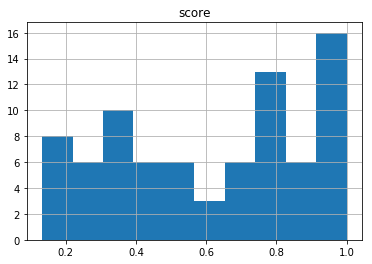

In [33]:
scores = pd.DataFrame.from_dict(data=checkpoint_files, orient='index')
scores.columns = ['score']
display(scores.head())
scores.hist()
scores_90 = scores[scores['score'] >= 0.90]
display(scores_90.describe())
display(scores_90)

## Analysis of Optimal Config 

* Seem to be converging around 5K epoch with 90+ accuracy. If we keep these settings on the model we can expect a more performing model for new test input.

## Reflection

* We started with a problem statement that will take input data with high, low, close and open prices for two market symbols and will develop a machine learning model that will provide consistent results beyond 50% accuracy. With a selection of multiple models, one would be chosen with high accuracy and a possibility of scaling up with more data. Something that can be easier to adjust with more data.
* We looked into data and preprocessed it for training. We added more features to data to get a better learning experience for our deep learning models.
* We selected four models to implement including three deep learning and one a simple classification model. The models were
   * SVM for simple classification with rbf kernel. We chose this model becaue it can work with non linear data and is pretty quick and cheap to implement.
   * Simple deep learning neural net with two hidden layers. We chose this model to get a better depth of learning that SVM could forget or ignore to accomodate while learning the entire data set at one time. Simple net along with other deep learning models use a stchastic approach which learns batch wise where a batch is a smaller subset of entire data set. This makes learning more efficient and can also learn more features than plain SVM.
   * Adding to simple net with two layers, we then added a CNN layer on top of hidden layers. Idea behind CNN layer is to learn a window of weights  together instead of one node at a time which is what happens in a simple neural net. In our case, we tried to learn eight (8) consequitive rows with all fifteen (15) features / columns in the matrix. We started with 15 matrices of 8/15 dimensions on the same input data that we fed Simple net. We then pooled a 2,2 stride on a max basis to reduce the next layer to 15 matrices of 4/4. The output of this layer was then fed into the simple net, thus making it even deeper! As expected this model learnt but came up with multiple optimas. __A difficult__ understanding to comprehend why 8/15 turned into 4/4. Also was difficult to come up with a matrix size that could work with the same batch as other models.
   * Adding to the depth of CNN, we then inserted a RNN layer between CNN and Simple Net. The window wide weights that we learnt in CNN then added more efficiency into RNN. In our case, we added eight (8) time steps of each cell size of 15 matching our feature columns. __ A difficult__ decision was to chose a proper batch size which is more than column sizes but still under our initial batch size. We chose 16 to make the final output 128/15. This selection also matches our plan to learn 8 rows together. Remember we tried to learn 8 rows together in CNN and now we want to learn 8 rows in sequence in RNN. The output of this layer was then fed into the Simple net, further improving efficiency.
   * We then evaluated all these models with pros and cons. We chose RNN model as the best choice fot not only giving us back the same average accuracy as SVM and Simple Net but showing that it learns faster and is more accurate in early learning cycles.
   * We then showed the Optimal configuration to use for this model for newer test set. We chose the cycle that returned most accurate scores. In our case it was 5K. We also showed the distribution of scores for this model.
   * __Conclusion Note__ It was difficult to prepare data for these models as most standard models come pre prepared with initial data. Like images come packed in image format (CNN) and words come packed in embeddings (RNN). Designing this data was a challenging task but was worth the effort. Another challenge was the steep learning curve in using Tensorflow. At the end, it was fruitful as TF gave a lot of tools for visualization. Another challenge was to come up with labels that suited each symbol appropriately. Putting it all together, it was a fun experience learning about all these models and was well worth the time and energy invested.

## Improvements

* More improvements in data preprocessing can improve model behavior. Increased size with more features to learn. Possibly a benchmark index data to add in as a feature like SNP prices etc.. More features and more records to learn will ideally benefit the deep learning models to better perform than our sample size of 20K/15 features. It will help with bias and overfitting.
* Different architectures / layer combinations is due for next phase. Instead of two simple layers of 10/5 we can use multiple layers of wider depth. Same thing for CNN and RNN as well.
* Make this model online by interpretting each record at a time. Doing this can make this model useful in real time or near real time.
* More visualization tools to chose a set of data to train on and test with. That will help chose important features that can add more value to the learning and leave the ones that do not participate much. It can also dive into a specific feature and tell how significant the effect is on the model behavior.